## ATCO inspection data

We've been given some excel spreadsheets from ATCO which have information about their pipeline failures and updates. Let's take a dig into this data and see what we can pull out...

### Tidy data

Before we can really do anyhing useful we need to load up the data. We've put all the data for this into the data directory - let's take a look at the files we've got 

In [1]:
import os            # library for interacting with your system
from os import path  # module for manipulating paths

# Let's find out where we're execting this at the moment
os.getcwd()

'/Users/jess/Documents/Core - Data Science Workshop/repositories/01-zero-to-data-science/notebooks'

Our data are in the data folder one directory above the notebook directory.

In [2]:
data_folder = path.join(
    path.abspath('..'),  # '..' means the directory above this one
    'data')
data_folder

'/Users/jess/Documents/Core - Data Science Workshop/repositories/01-zero-to-data-science/data'

In [3]:
os.listdir(data_folder)

['.DS_Store',
 '~$Mains_Age_Profile_Estimation 250516.xlsm',
 'Mains Faults Data_SAP_2010-2016.xlsx',
 'faults_data_2010_2016.feather',
 '~$Mains Faults Data_SAP_2010-2016.xlsx',
 'Mains_Age_Profile_Estimation 250516.xlsm']

Pandas will do most of the loading for us from a range of formats, including Excel. Let's load up the faults data

In [4]:
import pandas as pd

In [5]:
# This points to the location of the fault data file on my computer
fault_file = path.join(data_folder, 'Mains Faults Data_SAP_2010-2016.xlsx')

# First we need to see what sheets we have available in the book
faults_xl = pd.ExcelFile(fault_file)
faults_xl.sheet_names

['Method',
 'Catalogue Codes Desc',
 'All Notifications_2010-2016',
 'Pivot_Leaks_Mains Failure',
 'Pivot_Leaks_3rd Party',
 'Pivot_Leaks_Tree Roots',
 'Pivot_No Gas_Water in Main']

Now we can pick which sheet we want to play with. There's a few pivot tables (which we can recreate pretty simply in Python if required). However `All Notifications_2010-2016` looks most promising. 

In [6]:
df = faults_xl.parse('All Notifications_2010-2016')

> Note: We could have gone straight to this if we knew the names of the sheets by using `pandas.read_excel` and passing the sheet name. However it's useful sometimes to have the list of sheets in Python hence the approach we've taken above. You can try the alternative approach yourself

Let's take a look at this data

In [7]:
df.head()

,Notification,Notif.date,Notification Year,Code group,Damage Code,Code group.1,Cause code,Code group.2,ObjectPartCode,Functional Loc.,...,Priority,Priority Code,Description.1,User status,System status,Cause code text,City,Malfunct. start,Malfunct.end,Location
0,301049381,2011-05-20,2011,MNWORK,CHCK,MNREQUST,CUST,MNOBJECT,PIPE,00900834,...,NaN,SP,PIP 89 DRILLSHOT,INI NORD,NOCO NOPT,Customer Request,CAPEL,2011-05-20,2011-05-24,BS
1,301116137,2011-12-01,2011,MNWORK,CHCK,MNREQUST,AGAS,MNOBJECT,PIPE,00895059,...,NaN,SP,PIP 18 Access Rights Mandurah Gas Latera,INI,NOCO ORAS,AGN Request,PINJARRA,2011-12-01,NaT,MA
2,301630883,2015-08-17,2015,SNSERSTD,NEW,NaN,NaN,MNOBJECT,PIPE,01007110,...,NaN,SN,9 SLAB INSTALLATION,INI,OSNO,NaN,BASSENDEAN,2015-08-17,NaT,NM
3,300943307,2010-06-13,2010,MNWORK,CHCK,MNCAUSE,3PTY,MNOBJECT,PIPE,00876628,...,NaN,SP,PIP ****SITE VISIT****,INI NORD,ATCO NOCO,3rd Party Intervention,WANGARA,2010-06-07,2010-06-08,NM
4,301079516,2011-08-16,2011,MNWORK,CHCK,MNREQUST,CUST,MNOBJECT,PIPE,00898718,...,NaN,SP,PIP 1016 EXCAVTION,INI NORD,NOCO NOPT,Customer Request,ALKIMOS,2011-08-17,2011-08-17,NM


We can also get basic info about this dataframe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23021 entries, 0 to 23020
Data columns (total 31 columns):
Notification         23021 non-null int64
Notif.date           23021 non-null datetime64[ns]
Notification Year    23021 non-null int64
Code group           22498 non-null object
Damage Code          22498 non-null object
Code group.1         22439 non-null object
Cause code           22439 non-null object
Code group.2         23021 non-null object
ObjectPartCode       23021 non-null object
Functional Loc.      23020 non-null object
Description          23020 non-null object
Type                 23020 non-null object
Pressure Rating      22959 non-null object
Pipe Size            23013 non-null object
Pipe Material        22957 non-null object
Suburb               23008 non-null object
Street Name          22574 non-null object
Street Type          16211 non-null object
Street No.           15573 non-null object
Notifictn type       23021 non-null object
PriorityType         2302

Pandas has worked out a few things for us - it's identified which columns hold dates, and that the Notification ID is an integer. There are a lot of other columns which have variable data that Pandas doesn't want to guess what type would fit everything. Since most columns are 'objects' we are going to have to handle them individually.

So first we need to sort on basic data types. We could have columns that are:

1. floating-point numbers (`numpy.float`)
2. integers (`numpy.int`)
3. categories (`pandas.Categorical`)
4. strings (`str`)
5. dates/times (`pandas.DateTime`)
6. something else? (`pandas.Object`)

Pandas has seperate datatypes for each of these things. When cleaning our data we should try and map the columns to the relevant datatype. As we do this we will have to think about how to label invalid values, and what we'll do with records which have invalid values.

We'll show an example of this for a numeric value and one for a categorical distribution. In this dataset there are lots of misplaced values (probably due to bugs in the ingest software) so we will need to flag these as we go.

### Numeric values

The basic idea is to coerce the values to numeric and see what gets tossed out as a NaN (meaning Pandas couldn't infer a numerical value from that entry).

In [9]:
df.keys()

Index(['Notification', 'Notif.date', 'Notification Year', 'Code group',
       'Damage Code', 'Code group.1', 'Cause code', 'Code group.2',
       'ObjectPartCode', 'Functional Loc.', 'Description', 'Type',
       'Pressure Rating', 'Pipe Size', 'Pipe Material', 'Suburb ',
       'Street Name', 'Street Type', 'Street No. ', 'Notifictn type',
       'PriorityType', 'Priority', 'Priority Code', 'Description.1',
       'User status', 'System status', 'Cause code text', 'City',
       'Malfunct. start', 'Malfunct.end', 'Location'],
      dtype='object')

Let's try pipe size

In [10]:
pipe_size = pd.to_numeric(df['Pipe Size'], errors='coerce')

# We can make an array which is True for NaNs 
nans = pd.isna(pipe_size)
print('We have', nans.sum(), 'non-numeric entries')

# We can get a random sample of these entries to see what
# sort of non-numeric values are in this dataset
print('Five random entries:')
for entry in df['Pipe Size'][nans].sample(5):
    print(f' -- {entry}')

We have 297 non-numeric entries
Five random entries:
 -- FOSTER
 -- GAY
 -- MANNING
 -- ROBERTSON
 -- SHAFTESBURY


So it looks like theres a few misplaced fields in this dataset. We can check this for a few other columns as well. If it's not too bad we can just coerce everything we expect to be numeric and then drop rows with NaNs in later on.

Before we go too much further lets write our little exploration script into a function that we can call on a column in the dataframe.

In [11]:
def report_non_numeric_values(df, column, show=5):
    """
    Report on values in a given column which can't be coerced to 
    numeric values.
    
    Parameters:
        df - the dataframe holding our data
        column - the key denoting which column we'd like to 
            generate a report for
        show - how many random inavlid values to show. 
            Default is five random samples
    """
    # Make the NaN array all in one hit
    nans = pd.isna(pd.to_numeric(df[column], errors='coerce'))
    
    # Print our little report
    print(f'For column "{column}"')
    n_nans = nans.sum()
    if n_nans == 0:
        print('No non-numeric records found')
    else:
        print('We have', nans.sum(), 'non-numeric records')
        print('Some randomly-selected non-numeric records:')
        for entry in df[column][nans][:5]:
            print(f' -- {entry}')

We can also have a look at a categorical column and see what's going on. Usually you can spot these using the `pandas.nunique` function - we're looking for columns where there is a small number of unique values

In [12]:
df.nunique()

Notification         23017
Notif.date            2252
Notification Year        7
Code group               9
Damage Code             37
Code group.1             8
Cause code              22
Code group.2             1
ObjectPartCode          17
Functional Loc.      15483
Description          14124
Type                    11
Pressure Rating        158
Pipe Size              259
Pipe Material           30
Suburb                 602
Street Name           4695
Street Type            119
Street No.            1502
Notifictn type           4
PriorityType             4
Priority                22
Priority Code           38
Description.1        11395
User status             35
System status           20
Cause code text         24
City                   442
Malfunct. start       2253
Malfunct.end          2280
Location                 8
dtype: int64

Some of those make sense although pressure rating seems a bit strange - there are 158 values when there should only be a few of these. 

How do we know what to keep? There's a few ways of proceeding. Pandas has a useful `describe` method to quickly see what's happening in a column

In [13]:
df['Pressure Rating'].describe()

count     22959
unique      158
top          MP
freq       7637
Name: Pressure Rating, dtype: object

We can also count up how many of each we have

In [14]:
df['Pressure Rating'].value_counts()

MP            7637
HP            5580
MLP           3133
PEHP          2234
AMP           2068
CHP           1447
LP             447
FHP            113
PTH             20
NONE            11
E PTH            9
BAYSWTR          8
NTHBRDGE         5
YNGBP            5
FRSTFLD          5
NRBP             5
NLMRA            5
KLMSCT           5
MRLY             5
KWNA BCH         4
PNJRR            4
SCRT HRB         4
PLMYRA           4
JNDLE            4
N PTH            4
N FTLE           4
CLRKSN           3
RVRVLE           3
W PTH            3
HNTNGDLE         3
              ... 
BOYNP            1
OAKLY            1
KNWK             1
S KLGRLIE        1
ROSMYNE          1
LCKRDGE          1
LNGFD            1
GLDFD            1
BSNDN            1
CRGIE            1
WEMB DWN         1
KARNYP           1
ERSKNE           1
VIVSH            1
BOYA             1
EDN HLL          1
MOS PK           1
N BCH            1
WLRD             1
BLVUE            1
TRIGG            1
SEVLLE GRV  

So looks like there are some useful categories and then a bunch of mis-matched categories. 

We can clean this up by coercing the column to a categorical datatype. If we specify the categories ahead of time then anything that doesn't match will be assigned to the NaN category.

In [15]:
pressure_rating = pd.Categorical(
    df['Pressure Rating'],
    categories=('MP', 'HP', 'MLP', 'PEHP', 'AMP', 
                'CHP', 'LP', 'FHP')
)
pressure_rating.describe()

,counts,freqs
categories,,
MP,7637,0.331741
HP,5580,0.242387
MLP,3133,0.136093
PEHP,2234,0.097042
AMP,2068,0.089831
CHP,1447,0.062856
LP,447,0.019417
FHP,113,0.004909
NaN,362,0.015725


We can also plot the data up using Seaborn. Seaborn is a plotting library that knows how to generate a lot of different exploratory plots for you from pandas dataframes.

In [16]:
import seaborn
seaborn.set()  # let seaborn set up the notebook for plotting

In particular seaborn has a countplot instance that is useful here

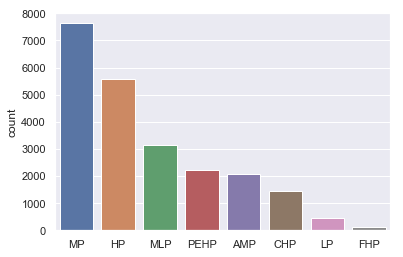

In [17]:
seaborn.countplot(pressure_rating)

We can do this for a bunch of the other categories as well

### Cleaned dataset

In addition to changing these columns 

In [18]:
df.set_index('Notification')
clean = pd.DataFrame(index=df.index)

# Stuff that we just copy across under a new name
make_copy = (
    ('Functional Loc.', 'functional_location'),
)

# Numeric columns
clean['pipe_size'] = pd.to_numeric(df['Pipe Size'], errors='coerce')

# Categorical columns
make_categorical = (  # has column, new_name, category pairs
    ('Code group', 'code_group_0', None),  # category = None means make everything into a category
    ('Code group.1', 'code_group_1', None),
#     ('Code group.2', 'code_group_2', None),  # only has MNOBJECT whatever that means
    ('Pressure Rating', 'pressure_rating', 
         ('MP', 'HP', 'MLP', 'PEHP', 'AMP', 
                         'CHP', 'LP', 'FHP')),
    ('Pipe Material', 'pipe_material', ('PVC', 'ST', 'PE', 'GI', 'CI')),
    ('Damage Code', 'damage_code', None),
    ('Cause code', 'cause_code', None),
    ('ObjectPartCode', 'object_part_code', None),
    ('Location', 'location', None)
)
for column, new_name, cats in make_categorical:
    clean[new_name] = pd.Categorical(df[column], categories=cats)
    
# Suburbs turns out to be tricky - here we hack together a list of valid categories to
# pass to pandas.Categorical. Alternative is to put together a manual list of values.
suburbs = df['Suburb '].str.rstrip(';')
ok_suburbs = [
    s for s in suburbs.unique()
    if not(isinstance(s, int) or isinstance(s, float))
    and len(list(filter(str.isdigit, s))) == 0  # will be > 0 if any digits in the string
]
clean['suburb'] = pd.Categorical(suburbs, categories=ok_suburbs)

Finally let's map some of the damage codes and suburbs to actual values

In [19]:
sorted(ok_suburbs)

['ABBY',
 'ALBNY',
 'ALFD CVE',
 'ALKMS',
 'ALXNDR HTS',
 'APLCRS',
 'ARDS',
 'ARMDLE',
 'ASCOT',
 'ASH',
 'ASHBY',
 'ATDALE',
 'ATWELL',
 'AUBIN GR',
 'AUSTRLND',
 'AVELEY',
 'BALGA',
 'BANJP',
 'BATMN',
 'BAYSWTR',
 'BCHBRO',
 'BCHLNDS',
 'BCNSFLD',
 'BCTN',
 'BDFDLE',
 'BEDFD',
 'BENNT SPRG',
 'BERTRAM',
 'BIB LKE',
 'BKNHM',
 'BLAJRA',
 'BLCTA',
 'BLDN',
 'BLDVS',
 'BLFF PNT',
 'BLIAR',
 'BLMT',
 'BLSBK',
 'BLVUE',
 'BNBRY',
 'BNKSIA GRV',
 'BNTLY',
 'BOORGN',
 'BOULDR',
 'BOVELL',
 'BOYA',
 'BOYNP',
 'BRABHAM',
 'BRD WOOD',
 'BRDWTR',
 'BRKDLE',
 'BRNS BCH',
 'BRNTWD',
 'BRSFRD',
 'BSLTN',
 'BSNDN',
 'BULL CK',
 'BURWD',
 'BUTLER',
 'BWICK',
 'BWICK JN',
 'BYFD',
 'CAMILLO',
 'CAPEL',
 'CARDUP',
 'CARINE',
 'CARRAMAR',
 'CASURNA',
 'CGEE',
 'CHMPN LKS',
 'CHRCHLDS',
 'CKBN CNTRL',
 'CLBLP',
 'CLBNIA',
 'CLIFTON',
 'CLLG GRV',
 'CLNGWDHGT',
 'CLNGWDPRK',
 'CLRKSN',
 'CLRMNT',
 'CLSTA',
 'CLVRDLE',
 'CNG VLE',
 'CNGTN',
 'CNNLY',
 'CNTNL PRK',
 'COLNGP',
 'COMO',
 'COODUP',
 'COTT',

Now we can check our clean data 

In [20]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23021 entries, 0 to 23020
Data columns (total 10 columns):
pipe_size           22724 non-null float64
code_group_0        22498 non-null category
code_group_1        22439 non-null category
pressure_rating     22659 non-null category
pipe_material       22776 non-null category
damage_code         22498 non-null category
cause_code          22439 non-null category
object_part_code    23021 non-null category
location            23020 non-null category
suburb              22724 non-null category
dtypes: category(9), float64(1)
memory usage: 432.8 KB


As a nice bonus our dataframe requires an order of magnitude less memory than before (~0.5 MB not ~5 MB)

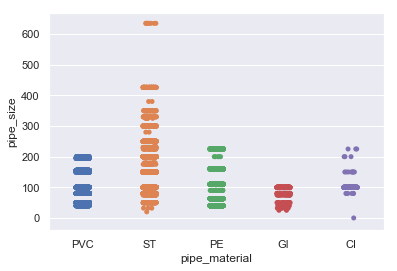

In [21]:
seaborn.stripplot(x='pipe_material', y='pipe_size', data=clean, jitter=True)

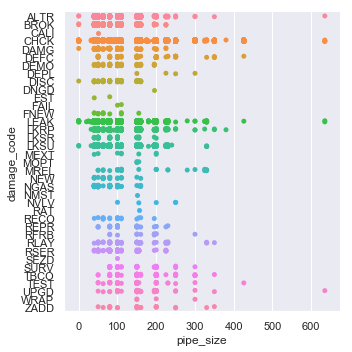

In [22]:
seaborn.catplot(x='pipe_size', y='damage_code', data=clean)

We need to serialize this data somehow. If we write it back out to CSV we lose all the work we've put into making these categorical data types. Instead we're going to use [feather](https://github.com/wesm/feather) - an open interoperable binary dataframe format that can be read in R, and Python and whatever else you want to use (Hadoop and friends spring to mind). 

In [23]:
feather_file = path.join(data_folder, 'faults_data_2010_2016.feather')
clean.to_feather(feather_file)

And we can read it straight back in with:

In [24]:
pd.read_feather(feather_file).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23021 entries, 0 to 23020
Data columns (total 10 columns):
pipe_size           22724 non-null float64
code_group_0        22498 non-null category
code_group_1        22439 non-null category
pressure_rating     22659 non-null category
pipe_material       22776 non-null category
damage_code         22498 non-null category
cause_code          22439 non-null category
object_part_code    23021 non-null category
location            23020 non-null category
suburb              22724 non-null category
dtypes: category(9), float64(1)
memory usage: 432.8 KB


/anaconda3/envs/week01/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


Notice that our categories are being maintained which is nice. 

As an aside you could now take this data over to R if you are more comfortable in that environment. To load the dataframe in R you could use something like:

```R
# install.packages("feather")
library(feather)
clean <- read_feather('/path/to/faults_data_2010_2016.feather')
```